# Ejemplos de Aplicacion, Gradientes - Optimizacion sin restricciones.

## Ejemplos de convergencia
1. Pueden encontrar algunos ejemplos en: https://gbhat.com/machine_learning/gradient_descent_learning_rates.html.
2. Tutorial de UVA Deep Learning. https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial4/Optimization_and_Initialization.html
3. varios ejemplos - optinpy. https://github.com/gusmaogabriels/optinpy
4. Ejemplos con JAX - https://colab.research.google.com/drive/1vrn43VMGrgExDZoOQISbnp01vJCu2IXV?usp=sharing
5. A Survey of Optimization Methods from a Machine Learning Perspective - https://arxiv.org/abs/1906.06821
6. Problemas de regresion y clasificacion.

# 1. Regresion

In [23]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from jax import numpy as jnp

X, Y = datasets.load_boston(return_X_y=True)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=123)

X_train, X_test, Y_train, Y_test = jnp.array(X_train, dtype=jnp.float32),\
                                   jnp.array(X_test, dtype=jnp.float32),\
                                   jnp.array(Y_train, dtype=jnp.float32),\
                                   jnp.array(Y_test, dtype=jnp.float32)

samples, features = X_train.shape

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

((404, 13), (102, 13), (404,), (102,))

In [24]:
samples, features

(404, 13)

Normalizar datos, que tengan medio 0 y varianza 1.

In [25]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

In [26]:
def InitializeWeights(layer_sizes, seed):
    weights = []

    for i, units in enumerate(layer_sizes):
        if i==0:
            w = jax.random.uniform(key=seed, shape=(units, features), minval=-1.0, maxval=1.0, dtype=jnp.float32)
        else:
            w = jax.random.uniform(key=seed, shape=(units, layer_sizes[i-1]), minval=-1.0, maxval=1.0,
                                   dtype=jnp.float32)

        b = jax.random.uniform(key=seed, minval=-1.0, maxval=1.0, shape=(units,), dtype=jnp.float32)

        weights.append([w,b])

    return weights

In [27]:
seed = jax.random.PRNGKey(123)
weights = InitializeWeights([5,10,1], seed)

for w in weights:
    print(w[0].shape, w[1].shape)

(5, 13) (5,)
(10, 5) (10,)
(1, 10) (1,)


In [28]:
def Relu(x):
    return jnp.maximum(x, jnp.zeros_like(x)) # max(0,x)

In [29]:
x = jnp.array([-1,0,1,-2,4,-6,5])

Relu(x)

Array([0, 0, 1, 0, 4, 0, 5], dtype=int32)

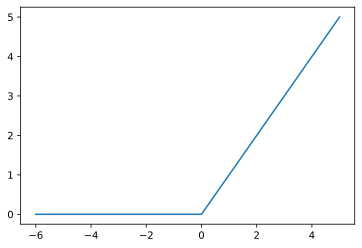

In [32]:
plt.plot(x.sort(),Relu(x.sort()))

In [33]:
def LinearLayer(weights, input_data, activation=lambda x: x):
    w, b = weights
    out = jnp.dot(input_data, w.T) + b
    return activation(out)

In [34]:
rand_data = jax.random.uniform(key=seed, shape=(5, X_train.shape[1]))

out = LinearLayer(weights[0], rand_data)

print("Data Shape : {}".format(rand_data.shape))
print("Output Shape : {}".format(out.shape))

Data Shape : (5, 13)
Output Shape : (5, 5)


In [35]:
def ForwardPass(weights, input_data):
    layer_out = input_data

    for i in range(len(weights[:-1])):
        layer_out = LinearLayer(weights[i], layer_out, Relu)

    preds = LinearLayer(weights[-1], layer_out)

    return preds.squeeze()

Funcion objetivo: Error medio cuadratico
$$ \min f(\mathbf{X}_{(N,D)}) = ∑_{n=1}^N (y_n - \text{NN}(\mathbf{x}_n))^2  $$

In [36]:
def MeanSquaredErrorLoss(weights, input_data, actual):
    preds = ForwardPass(weights, input_data)
    return jnp.power(actual - preds, 2).mean()

In [37]:
from jax import grad, value_and_grad

def CalculateGradients(weights, input_data, actual):
    Grad_MSELoss = grad(MeanSquaredErrorLoss)
    gradients = Grad_MSELoss(weights, input_data, actual)
    return gradients

In [38]:
def TrainModel(weights, X, Y, learning_rate, epochs):
    for i in range(epochs):
        loss = MeanSquaredErrorLoss(weights, X, Y)
        gradients = CalculateGradients(weights, X, Y)

        ## Update Weights
        for j in range(len(weights)):
            weights[j][0] -= learning_rate * gradients[j][0] ## Update Weights
            weights[j][1] -= learning_rate * gradients[j][1] ## Update Biases

        if i%100 ==0: ## Print MSE every 100 epochs
            print("MSE : {:.2f}".format(loss))

In [39]:
seed = jax.random.PRNGKey(42)
learning_rate = jnp.array(1/1e3)
epochs = 1500
layer_sizes = [5,10,15,1]

weights = InitializeWeights(layer_sizes, seed)

TrainModel(weights, X_train, Y_train, learning_rate, epochs)

MSE : 583.43
MSE : 16.18
MSE : 13.83
MSE : 12.62
MSE : 11.88
MSE : 11.34
MSE : 10.91
MSE : 10.51
MSE : 10.14
MSE : 9.80
MSE : 9.51
MSE : 9.27
MSE : 9.04
MSE : 8.79
MSE : 8.51


In [40]:
test_preds = ForwardPass(weights, X_test)

test_preds[:5], Y_test[:5]

(Array([24.394611, 27.70039 , 44.80102 , 21.503696, 27.354103], dtype=float32),
 Array([15. , 26.6, 45.4, 20.8, 34.9], dtype=float32))

In [42]:
train_preds = ForwardPass(weights, X_train)

train_preds[:5], Y_train[:5]

(Array([46.307198, 12.954236, 21.248285, 27.865353, 18.95947 ], dtype=float32),
 Array([48.5, 17.1, 23.1, 28.4, 18.9], dtype=float32))

Desempeño del modelo

In [43]:
print("Test  MSE Score : {:.2f}".format(MeanSquaredErrorLoss(weights, X_test, Y_test)))
print("Train MSE Score : {:.2f}".format(MeanSquaredErrorLoss(weights, X_train, Y_train)))

Test  MSE Score : 17.89
Train MSE Score : 8.28


In [44]:
from sklearn.metrics import r2_score

print("Test  R^2 Score : {:.2f}".format(r2_score(test_preds.squeeze(), Y_test)))
print("Train R^2 Score : {:.2f}".format(r2_score(train_preds.squeeze(), Y_train)))

Test  R^2 Score : 0.75
Train R^2 Score : 0.89


# Clasificacion

In [45]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

X, Y = datasets.load_breast_cancer(return_X_y=True)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, stratify=Y, random_state=123)

X_train, X_test, Y_train, Y_test = jnp.array(X_train, dtype=jnp.float32),\
                                   jnp.array(X_test, dtype=jnp.float32),\
                                   jnp.array(Y_train, dtype=jnp.float32),\
                                   jnp.array(Y_test, dtype=jnp.float32)

samples, features = X_train.shape
classes = np.unique(Y)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((455, 30), (114, 30), (455,), (114,))

In [46]:
samples, features, classes

(455, 30, array([0, 1]))

In [47]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

In [48]:
def InitializeWeights(layer_sizes, seed):
    weights = []
    for i, units in enumerate(layer_sizes):
        if i==0:
            w = jax.random.uniform(key=seed, shape=(units, features), minval=-1.0, maxval=1.0, dtype=jnp.float32)
        else:
            w = jax.random.uniform(key=seed, shape=(units, layer_sizes[i-1]), minval=-1.0, maxval=1.0,
                                   dtype=jnp.float32)

        b = jax.random.uniform(key=seed, minval=-1.0, maxval=1.0, shape=(units,), dtype=jnp.float32)

        weights.append([w,b])

    return weights

In [49]:
def Sigmoid(x):
    return 1 / (1 + jnp.exp(-1 * x))

In [50]:
arr = jnp.array([1,2,3,4,5], dtype=jnp.float32)

Sigmoid(arr), jax.nn.sigmoid(arr)

(Array([0.7310586 , 0.880797  , 0.95257413, 0.98201376, 0.9933072 ],      dtype=float32),
 Array([0.7310586 , 0.880797  , 0.95257413, 0.98201376, 0.9933072 ],      dtype=float32))

In [51]:
def LinearLayer(weights, input_data, activation=lambda x: x):
    w, b = weights
    out = jnp.dot(input_data, w.T) + b
    return activation(out)

In [52]:
def ForwardPass(weights, input_data):
    layer_out = input_data

    for i in range(len(weights[:-1])):
        layer_out = LinearLayer(weights[i], layer_out, Relu)

    preds = LinearLayer(weights[-1], layer_out, Sigmoid)
    return preds.squeeze()

In [53]:
def NegLogLoss(weights, input_data, actual):
    preds = ForwardPass(weights, input_data)
    return (- actual * jnp.log(preds) - (1 - actual) * jnp.log(1 - preds)).mean()

In [54]:
from jax import grad, value_and_grad

def CalculateGradients(weights, input_data, actual):
    Grad_NegLogLoss = grad(NegLogLoss)
    gradients = Grad_NegLogLoss(weights, input_data, actual)
    return gradients

In [55]:
def TrainModel(weights, X, Y, learning_rate, epochs):
    for i in range(epochs):
        loss = NegLogLoss(weights, X, Y)
        gradients = CalculateGradients(weights, X, Y)

        ## Update Weights
        for j in range(len(weights)):
            weights[j][0] -= learning_rate * gradients[j][0] ## Update Weights
            weights[j][1] -= learning_rate * gradients[j][1] ## Update Biases

        if i%100 ==0:  ## Print LogLoss every 100 epochs
            print("NegLogLoss : {:.2f}".format(loss))

In [56]:
seed = jax.random.PRNGKey(42)
learning_rate = jnp.array(1/1e2)
epochs = 1500
layer_sizes = [5,10,15,1]

weights = InitializeWeights(layer_sizes, seed)

TrainModel(weights, X_train, Y_train, learning_rate, epochs)

NegLogLoss : 1.21
NegLogLoss : 0.33
NegLogLoss : 0.26
NegLogLoss : 0.23
NegLogLoss : 0.20
NegLogLoss : 0.17
NegLogLoss : 0.16
NegLogLoss : 0.14
NegLogLoss : 0.13
NegLogLoss : 0.12
NegLogLoss : 0.11
NegLogLoss : 0.11
NegLogLoss : 0.10
NegLogLoss : 0.10
NegLogLoss : 0.09


In [57]:
test_preds = ForwardPass(weights, X_test)

test_preds = (test_preds > 0.5).astype(jnp.float32)

test_preds[:5], Y_test[:5]

(Array([0., 0., 1., 1., 0.], dtype=float32),
 Array([0., 0., 1., 1., 1.], dtype=float32))

In [58]:
train_preds = ForwardPass(weights, X_train)

train_preds = (train_preds > 0.5).astype(jnp.float32)

train_preds[:5], Y_train[:5]

(Array([1., 1., 0., 0., 1.], dtype=float32),
 Array([1., 1., 0., 0., 1.], dtype=float32))

In [59]:
print("Test  NegLogLoss Score : {:.2f}".format(NegLogLoss(weights, X_test, Y_test)))
print("Train NegLogLoss Score : {:.2f}".format(NegLogLoss(weights, X_train, Y_train)))

Test  NegLogLoss Score : 0.11
Train NegLogLoss Score : 0.09


In [60]:
from sklearn.metrics import accuracy_score

print("Train Accuracy : {:.2f}".format(accuracy_score(Y_train, train_preds)))
print("Test  Accuracy : {:.2f}".format(accuracy_score(Y_test, test_preds)))

Train Accuracy : 0.98
Test  Accuracy : 0.97
